## Importing the relevant packages


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA

from tools.metrics_generator import MetricsGenerator
from tools.model_generator import ModelGenerator

sns.set_theme(context="notebook", style="white")

## Importing the Data and Pre-processing 

In [2]:
raw_csv_data = pd.read_csv("Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)
df_comp = df_comp.asfreq("b")
df_comp = df_comp.ffill()

In [3]:
df_comp["market_value"] = df_comp.ftse

In [4]:
del df_comp["spx"]
del df_comp["dax"]
del df_comp["ftse"]
del df_comp["nikkei"]

# Split into train and test sets
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

## The ACF

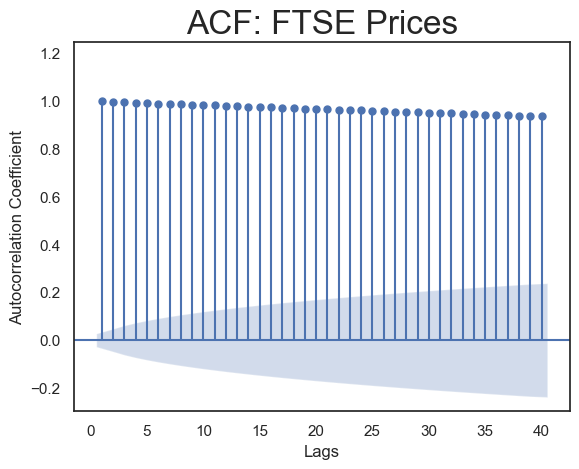

In [5]:
sgt.plot_acf(df["market_value"], zero=False, lags=40, auto_ylims=True)
plt.title("ACF: FTSE Prices", size=24)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation Coefficient")
plt.show()

- The coefficients slowly decline with lags.
- All are positive.
- All are significant.
- This is similar to the ACF for the S&P500 conducted previously.

- A higher number of lags means a more coefficients and a better fit but makes the model prone to overfitting and poor generalisation.
- A parsimonious model with fewer lags is better.
- An efficient model should only include lags which have a **direct**, **significant** effect on the present value. This is determined using the PACF.

## The PACF

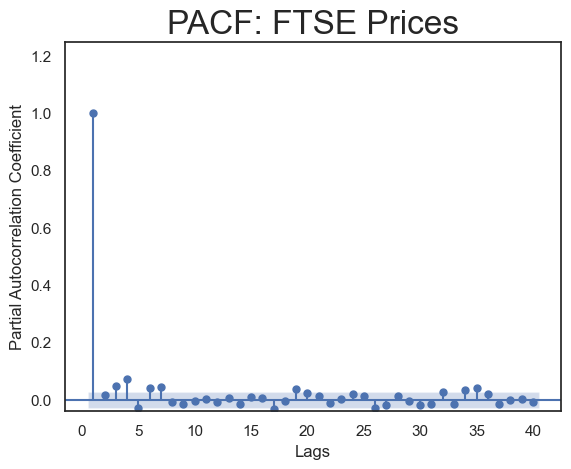

In [6]:
sgt.plot_pacf(
    df["market_value"], alpha=0.05, zero=False, lags=40, method="ols", auto_ylims=True
)

plt.title("PACF: FTSE Prices", size=24)
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation Coefficient")
plt.show()

- The first lag coefficient is greatly significant and **must** be included in the model.
- Coefficients from lag 25 onwards are not significant and can be ignored. Since their values will be very close to 0, their impact on the model will be minimal.
- The model should therefore include less than 25 lags.
- A business month is 22 days, which means there will be cyclical changes. Values a month ago negatively affect the values today. However, these are overshadowed by more recent lags and their contribution should not be overanalysed.
- NB Patterns are not always so convenient to spot.

## The AR(1) Model

In [7]:
model_prices = ARIMA(df["market_value"], order=(1, 0, 0))
result_prices = model_prices.fit()
result_prices.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27622.604
Date:                Wed, 28 Jan 2026   AIC                          55251.207
Time:                        10:25:24   BIC                          55270.772
Sample:                    01-07-1994   HQIC                         55258.063
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6374    423.329     12.023      0.000    4259.929    5919.346
ar.L1          0.9984      0.001   1147.578      0.000       0.997       1.000
sigma2      3511.3842     40.874     85.907      0.000    3431.272    3591.496
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):              3313.33
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- `const` refers to $C$. `coef` is its value.
- `ar.L1` refers to `'market_value`. `coef` refers to $\phi_1$, which is the coefficient for the autoregressive value for 1 time period ago ($t-1$).
  - The coefficient is close to 1, which is similar to what the ACF and PACF graph indicate.

- As the $P$ values for both are 0.00, both $C$ and $\phi_1$ for market value are significant.

- As the **critical values** for both do not contain 0, both the coefficients are significant.

Since both values are significantly different from 0, a more complex model can be tried for greater accuracy.

## Higher-Lag AR Models

In [8]:
model_generator_prices = ModelGenerator(data=df["market_value"])
max_lags = 9
param_grid = [{"order": (p, 0, 0)} for p in range(1, max_lags + 1)]
model_generator_prices.generate_models(
    model_function=ARIMA, model_name_prefix="AR", param_grid=param_grid
)

model_generator_prices.summarise_results()

AR_1_0_0:
                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -27622.604
Date:                Wed, 28 Jan 2026   AIC                          55251.207
Time:                        10:25:38   BIC                          55270.772
Sample:                    01-07-1994   HQIC                         55258.063
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5089.6374    423.329     12.023      0.000    4259.929    5919.346
ar.L1          0.9984      0.001   1147.578      0.000       0.997       1.000
sigma2      3511.3842     40.874     85.90

**AR(2)**
- The coefficients for $C$ and $\phi_1$ have changed. This is because some of the changes contributing to the present value can be attributed to lag 2.
- `ar.L2` has been added for lag 2. As the $P$ value for L2 is > 0.05, it indicates that $\phi_2$ is not significantly different from 0. Also, its **critical value** range contains 0.
- The log likelihood is slightly higher than that for AR(1).

**AR(3)**
- $\phi_2$ is now negative. Its P value is below 0.05, which indicates significance.
- The P value of $\phi_3$ is 0, which indicates that it is significant.
- The log likelihood is higher than both AR(1) and AR(2)

**AR(4)**
- The P value of $\phi_3$ is more than 0.05, which indicates that it is not significant.
- The log likelihood is higher than the AR(1) to AR(3) models, which suggests that the model is capturing more variation in the data.
- However, the insignificance of $\phi_3$ raises concerns about overfitting.

#### Create a dataframe to tabulate measures of interest

In [9]:
metrics_prices = MetricsGenerator(models=model_generator_prices.models)
metrics_prices.generate_metrics_table()
metrics_prices.evaluation

,ar,ma,llf,aic,bic,hqic,final_lag,final_lag_pval,llr_test_models,llr_test_pval
model,,,,,,,,,,
AR_1_0_0,1,0,-27622.603677,55251.207355,55270.771508,55258.062828,ar.L1,0.00000,NaN,NaN
AR_2_0_0,2,0,-27621.949238,55251.898476,55277.984014,55261.039107,ar.L2,0.08031,AR_2_0_0 vs AR_1_0_0,2.525978e-01
AR_3_0_0,3,0,-27615.962469,55241.924938,55274.531860,55253.350726,ar.L3,0.00000,AR_3_0_0 vs AR_2_0_0,5.396137e-04
AR_4_0_0,4,0,-27602.679627,55217.359253,55256.487560,55231.070199,ar.L4,0.00000,AR_4_0_0 vs AR_3_0_0,2.547283e-07
AR_5_0_0,5,0,-27600.460068,55214.920136,55260.569827,55230.916240,ar.L5,0.00093,AR_5_0_0 vs AR_4_0_0,3.512441e-02
AR_6_0_0,6,0,-27596.586792,55209.173585,55261.344660,55227.454846,ar.L6,0.00001,AR_6_0_0 vs AR_5_0_0,5.381520e-03
AR_7_0_0,7,0,-27592.022013,55202.044026,55260.736485,55222.610444,ar.L7,0.00001,AR_7_0_0 vs AR_6_0_0,2.515123e-03
AR_8_0_0,8,0,-27591.854092,55203.708184,55268.922028,55226.559760,ar.L8,0.41490,AR_8_0_0 vs AR_7_0_0,5.622391e-01
AR_9_0_0,9,0,-27591.280384,55204.560769,55276.295997,55229.697503,ar.L9,0.14329,AR_9_0_0 vs AR_8_0_0,2.840910e-01


In [10]:
# Find models where both the final lag and the LLR Test p-values fail to reach significance.
metrics_prices.evaluation.query("final_lag_pval >= 0.05 and llr_test_pval >= 0.05")

,ar,ma,llf,aic,bic,hqic,final_lag,final_lag_pval,llr_test_models,llr_test_pval
model,,,,,,,,,,
AR_2_0_0,2,0,-27621.949238,55251.898476,55277.984014,55261.039107,ar.L2,0.08031,AR_2_0_0 vs AR_1_0_0,0.252598
AR_8_0_0,8,0,-27591.854092,55203.708184,55268.922028,55226.559760,ar.L8,0.41490,AR_8_0_0 vs AR_7_0_0,0.562239
AR_9_0_0,9,0,-27591.280384,55204.560769,55276.295997,55229.697503,ar.L9,0.14329,AR_9_0_0 vs AR_8_0_0,0.284091


**Plot the test metrics.**

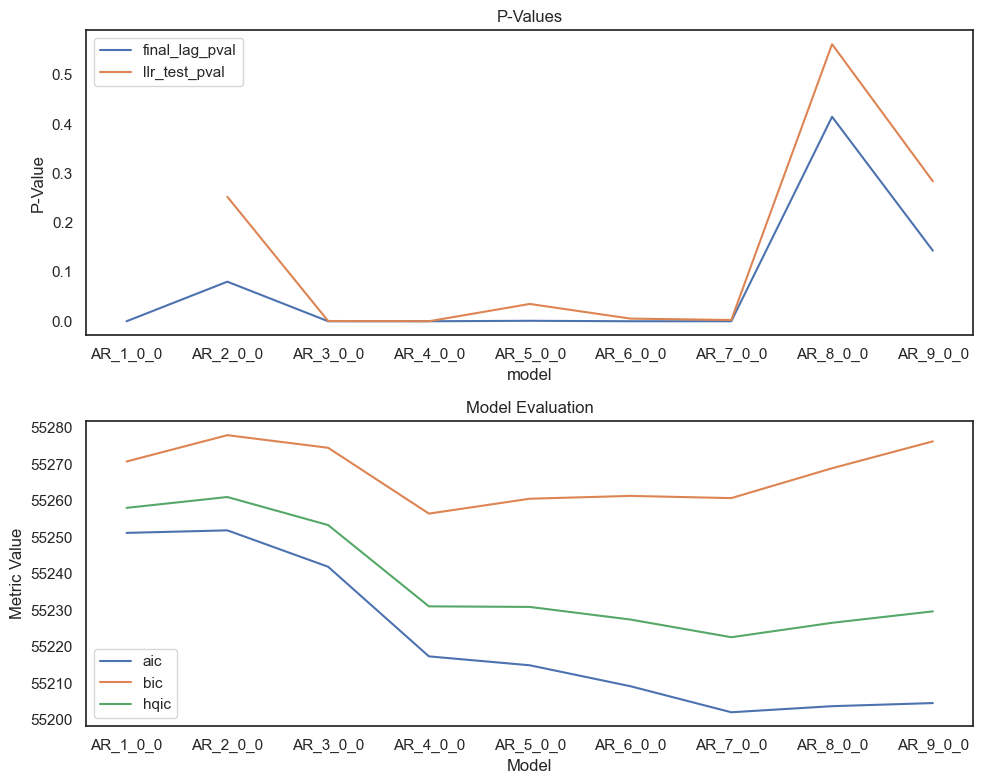

In [11]:
# Create 2 subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot final lag p-value on the first subplot
metrics_prices.evaluation[["final_lag_pval", "llr_test_pval"]].plot(ax=axes[0])
axes[0].set_title("P-Values")
axes[1].set_xlabel("Model")
axes[0].set_ylabel("P-Value")

# Plot AIC, BIC, HQIC on the second subplot
metrics_prices.evaluation[["aic", "bic", "hqic"]].plot(ax=axes[1])
axes[1].set_title("Model Evaluation")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Metric Value")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

- The first model which satisfies the p-values of both the final lag and the LLR Test being non-significant is AR(2). The next is AR(8)
- Model AR(7) is selected and a LLR Test is performed against AR(1) to confirm significance.

In [19]:
# Calculate degrees of freedom from the maximum lags of each model
deg_freedom_prices = (
    metrics_prices.evaluation.loc["AR_7_0_0", "ar"]
    - metrics_prices.evaluation.loc["AR_1_0_0", "ar"]
)

metrics_prices.llr_test(
    metrics_prices.evaluation.loc["AR_1_0_0", "llf"],
    metrics_prices.evaluation.loc["AR_7_0_0", "llf"],
    df=deg_freedom_prices,
)

np.float64(2.611121764082541e-11)

The returned p-value indicates that the AR_7 model is significanlty better than the AR_1 model.

## Analysing the Residuals

In [13]:
# Get residuals from the AR_7 model result
df["residuals_price"] = model_generator_prices.get_model("AR_7")[1].resid

In [14]:
df["residuals_price"].mean()

np.float64(0.3519708988807973)

In [15]:
df["residuals_price"].var()

np.float64(4005.822045824129)

<Axes: >

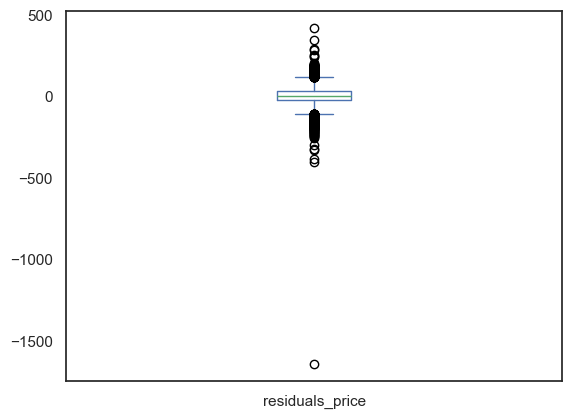

In [16]:
df["residuals_price"].plot.box()

- The mean is close to 0, which suggests that the model performs well.
- However, the high variance indicates that the model might not perform well.

In [17]:
# ADF Test
sts.adfuller(df["residuals_price"])

(np.float64(-76.05339410641189),
 0.0,
 0,
 5020,
 {'1%': np.float64(-3.431653316130827),
  '5%': np.float64(-2.8621159253018247),
  '10%': np.float64(-2.5670765656497516)},
 np.float64(54842.158740221246))

- The **ADF** t-statistic is much more negative than the the 5% critical value and the p-value is 0, both of which suggest stationarity.

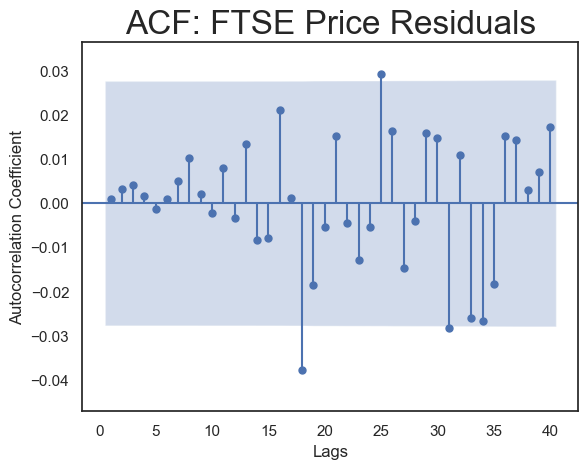

In [18]:
# Plot the ACF for residuals
sgt.plot_acf(df["residuals_price"], zero=False, lags=40, auto_ylims=True)
plt.title("ACF: FTSE Price Residuals", size=24)
plt.xlabel("Lags")
plt.ylabel("Autocorrelation Coefficient")
plt.show()

The majority of residuals are not significantly different from 0, which fits the characteristics of white noise. However, the 3 values that are significantly different from 0 indicate that there might be a better predictor.

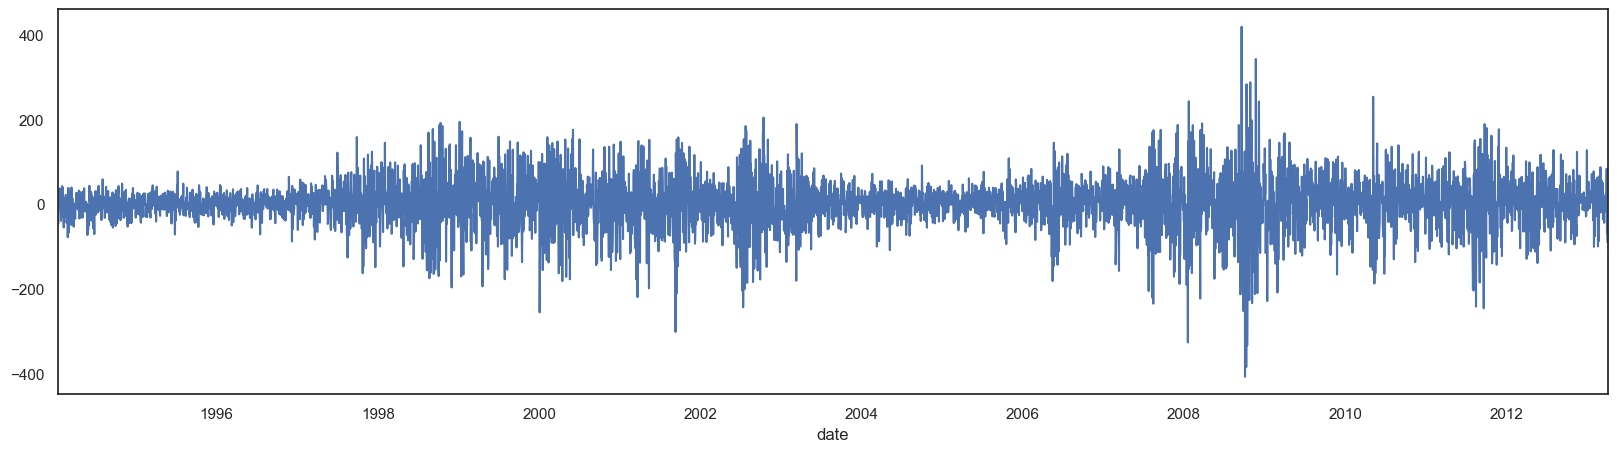

In [19]:
# Plot the residual time series.
# The first row is dropped as it is an outlier, which is expected for AR model residuals.
df["residuals_price"][1:].plot(figsize=(20, 5))
plt.show()

- The price residuals are mostly low and the time series does not indicate an obvious pattern, so the choice of model seems correct.
- However, since an AR model is being used on non-stationary data, the predictions might still be incorrect.